In [16]:
!pip install pygame

In [17]:
import random
from itertools import combinations
import pygame

In [18]:
helpful_macpan_color = (0, 255, 0)
unhelpful_macpan_color = (255, 0, 0)
tittat_macpan_color = (255, 255, 0)
canteen_color = (51, 51, 204)
bg_color = (0, 0 , 0)
block_size = 5

In [19]:
# Environment Parameters
HEIGHT = 150
WIDTH = 150
INITIAL_HELPUL_POP = 100
INITIAL_TITTAT_POP = 100
INITIAL_UNHELPFUL_POP = 100
MOVEMENTS_PER_DAY = 24
CANTEEN_COUNT = 50
CANTEED_FOOD_PER_PERSON = 30
CANTEEN_DAILY_FOOD_LIMIT = 80 * CANTEED_FOOD_PER_PERSON
CANTEEN_REAPPEAR_TIME = MOVEMENTS_PER_DAY*5
GHOST_VAL = 8
FOOD_THRESHOLD_FOR_REPRODUCTION = 40
FOOD_COST_PER_MOVE = 1 / MOVEMENTS_PER_DAY
MIN_START_FOOD = 20

# QLearning Parameters
LEARNING_RATE = 0.1
START_EXPLORATION_PROB = 1
MIN_EXPLORATION_PROB = 0.4
DISCOUNT = 0.9
EXPL_RATE_DECAY = 0.001
REPRODUCTION_REWARD = FOOD_THRESHOLD_FOR_REPRODUCTION
VISION_RADIUS = 10
VISION_MOVEMENT_PROB = 0.2

In [20]:
population_current = 0
helpful_pop = 0
unhelpful_pop = 0
tittat_pop = 0
population_initial = INITIAL_HELPUL_POP + INITIAL_TITTAT_POP + INITIAL_UNHELPFUL_POP
total_interactions = 0
ID = 0

macpens_dict = {}
macpens_loc_dict = {}
canteens_loc_dict = {}se

In [21]:
class canteen(pygame.sprite.Sprite):
    def __init__(self, x, y):
        super().__init__()
        self.image = pygame.Surface((block_size, block_size))
        self.image.fill(canteen_color)
        self.rect = self.image.get_rect()
        self.rect.x = x*block_size
        self.rect.y = y*block_size

        self.x = x
        self.y = y
        self.available_food = CANTEEN_DAILY_FOOD_LIMIT
        self.fed_ids = set()
    
    def can_feed_macpen(self, id):
        return self.available_food > 0 and id not in self.fed_ids

    def feed_macpen(self, id):
        self.fed_ids.add(id)
        self.available_food -= CANTEED_FOOD_PER_PERSON
    
    def reset(self):
        self.fed_ids = set()
        self.available_food = CANTEEN_DAILY_FOOD_LIMIT
    
    def draw(self, surface):
        pygame.draw.rect(surface, canteen_color, (self.rect.x, self.rect.y, block_size, block_size))
        
    def update(self):
        self.draw(screen)


In [22]:
class QLearningAgent:
    def __init__(self, lr, epsilon, discount):
        self.lr = lr # learning rate
        self.epsilon = epsilon # exploration rate
        self.discount = discount # discount rate
        self.q_table = {} # dictionary to store Q-values
    
    def get_q_value(self, state, action):
        if (state, action) not in self.q_table:
            self.q_table[(state, action)] = 0.0
        return self.q_table[(state, action)]
    
    def update_q_value(self, state, action, reward, next_state):
        q_value = self.get_q_value(state, action) 
        next_q_value = float('-inf')
        for a in ["left", "right", "up", "down"]:
            next_q_value = max(next_q_value, self.get_q_value(next_state, a))
        temporal_difference = reward + (self.discount * next_q_value)
        self.q_table[(state, action)] = (1-self.lr)*self.q_table[(state, action)] + self.lr * temporal_difference
        self.epsilon = max(self.epsilon * (1 - EXPL_RATE_DECAY), MIN_EXPLORATION_PROB)
    
    def reset_q_table(self):
        self.q_table = {}
    
    def get_best_action(self, state, actions):
        if random.random() < self.epsilon:
            return random.choice(actions)
        else:
            best_q_value = float('-inf')
            for action in actions:
                q_value = self.get_q_value(state, action)
                if q_value >= best_q_value:
                    best_action = action
                    best_q_value = q_value
            return best_action

In [23]:
def get_position(x, y, action):
  if action == "up":
    return (x, y+1)
  if action == "down":
    return (x, y-1)
  if action == "left":
    return (x-1, y)
  return (x+1, y)

def is_nearer(action, p_source, p_target):
  if action == "left":
    return p_source[0] > p_target[0]
  if action == "right":
    return p_source[0] < p_target[0]
  if action == "up":
    return p_source[1] < p_target[1]
  return p_source[1] > p_target[1]

In [24]:
class macpen(pygame.sprite.Sprite):
    x = None
    y = None
    Type = None
    food = random.randint(MIN_START_FOOD, FOOD_THRESHOLD_FOR_REPRODUCTION)
    ID = None
    donate = None
    movement_weights = [1, 1, 1, 1]
    agent = QLearningAgent(LEARNING_RATE, START_EXPLORATION_PROB, DISCOUNT)
    prev_state = None
    last_action = ""
    prev_food = 0
    reproduction_reward = 0
    nearest_canteen = None

    def __init__(self, x, y, color):
        super().__init__()
        self.image = pygame.Surface((block_size, block_size))
        self.image.fill(color)
        self.color = color
        self.rect = self.image.get_rect()
        self.rect.x = x*block_size
        self.rect.y = y*block_size
        self.x = x
        self.y = y

    def move(self):
        # choose action based on epsilon-greedy policy
        actions = []
        expl_prob = random.random()
        move_nearer = False
        if expl_prob < VISION_MOVEMENT_PROB:
            move_nearer = True
        if self.nearest_canteen is not None and move_nearer:
            cur_loc = (self.x, self.y)
            tar_loc = self.nearest_canteen
            if self.x > 1 and is_nearer("left", cur_loc, tar_loc):
                actions.append("left")
            if self.x < WIDTH and is_nearer("right", cur_loc, tar_loc):
                actions.append("right")
            if self.y > 1 and is_nearer("down", cur_loc, tar_loc):
                actions.append("down")
            if self.y < HEIGHT and is_nearer("up", cur_loc, tar_loc):
                actions.append("up")
        if self.nearest_canteen == None or not move_nearer or len(actions) == 0:
            if self.x > 1:
                actions.append("left")
            if self.x < WIDTH:
                actions.append("right")
            if self.y > 1:
                actions.append("down")
            if self.y < HEIGHT:
                actions.append("up")
        
    
        state = (self.x, self.y)
        self.prev_state = state
        self.prev_food = self.food
        action = self.agent.get_best_action(state, actions)
        self.last_action = action

        # take action and observe reward and next state
        final_x, final_y = get_position(self.x, self.y, action)
        self.x = final_x
        self.y = final_y
        self.rect.x = self.x*block_size
        self.rect.y = self.y*block_size
        self.food -= FOOD_COST_PER_MOVE
    
    def update_q_table(self):
        prev_state = self.prev_state
        action = self.last_action
        reward = self.food - self.prev_food + self.reproduction_reward
        self.reproduction_reward = 0
        next_state = (self.x, self.y)
        # update Q-value
        self.agent.update_q_value(prev_state, action, reward, next_state)
    
    
    def interact(self,m):
        excess1 = self.food - (GHOST_VAL + FOOD_COST_PER_MOVE*MOVEMENTS_PER_DAY*2)
        excess2 = m.getExcess()
        
        if(excess1*excess2 > 0):
            pass
        elif(excess1*excess2 < 0):
            if(excess1 > 0 and self.Type == "helpful"):
                require = abs(excess2)
                self.food -= min(excess1, require)
                m.food += min(excess1, require)
            elif(excess2 > 0 and m.Type == "helpful"):
                require = abs(excess1)
                self.food += min(excess2, require)
                m.food -= min(excess2, require)
            elif(excess1 > 0 and m.Type == "tittat" and m.donate >= 0):
                require = abs(excess2)
                self.food -= min(excess1, require)
                m.food += min(excess1, require)
                if(m.Type == "helpful" or m.Type == "unhelpful"):
                    self.donate += m.donate
                elif(m.Type == "tittat" and m.donate > 0):
                    self.donate += 1
                elif(m.Type == "tittat" and m.donate < 0):
                    self.donate -= 1
            elif(excess2 > 0 and m.Type == "tittat" and self.donate >= 0):
                require = abs(excess1)
                m.food -= min(excess2, require)
                self.food += min(excess2, require)
                if(self.Type == "helpful" or self.Type == "unhelpful"):
                    m.donate += self.donate
                elif(self.Type == "tittat" and self.donate > 0):
                    m.donate += 1
                elif(self.Type == "tittat" and self.donate < 0):
                    m.donate -= 1
        else:
            pass
    
    def can_reproduce(self):
        if self.food >= FOOD_THRESHOLD_FOR_REPRODUCTION:
            return True
        else:
            return False
    
    def setPosition(self, x, y):
        self.x = x
        self.y = y
    
    def getExcess(self):
        return self.food - (GHOST_VAL + FOOD_COST_PER_MOVE*MOVEMENTS_PER_DAY*2)
    
    def getPosition(self):
        return (self.x, self.y)
    
    def getLocId(self):
        return (self.y)*HEIGHT + self.x

    def draw(self, surface):
        pygame.draw.rect(surface, self.color, (self.rect.x, self.rect.y, block_size, block_size))

    def update(self):
        self.draw(screen)


In [25]:
   
class macpen_helpful(macpen): 
    def __init__(self, x, y):
        super().__init__(x, y, helpful_macpan_color)
        self.Type = "helpful"
        self.ID = ID
        self.donate = 1
        
    def reproduce(self, reward):
        m = macpen_helpful(self.x, self.y)        
        self.food = self.food/2
        m.food = self.food
        m.Type = "helpful"
        self.reproduction_reward = reward
        return m      


class macpen_tittat(macpen): 
    def __init__(self, x, y):
        super().__init__(x, y, tittat_macpan_color)
        self.Type = "tittat"
        self.ID = ID
        self.donate = 0
    
    def reproduce(self, reward):
        m = macpen_tittat(self.x, self.y)
        self.food = self.food/2
        m.food = self.food
        m.Type = "tittat"
        self.reproduction_reward = reward        
        return m 


class macpen_unhelpful(macpen):
    def __init__(self, x, y):
        super().__init__(x, y, unhelpful_macpan_color)
        self.Type = "unhelpful"
        self.ID = ID
        self.donate = -1
    
    def reproduce(self, reward):
        m = macpen_unhelpful(self.x, self.y)
        self.food = self.food/2
        m.food = self.food
        m.Type = "unhelpful"
        self.reproduction_reward = reward  
        return m 
    

In [26]:
def create_macpen(type):  
    global helpful_pop, tittat_pop, unhelpful_pop, ID, population_current  
    x = random.randint(0,WIDTH-1)
    y = random.randint(0,HEIGHT-1)

    if type == "helpful":
        m = macpen_helpful(x, y)
        helpful_pop += 1
    elif type == "tittat":
        m = macpen_tittat(x, y)
        tittat_pop += 1
    elif type == "unhelpful":
        m = macpen_unhelpful(x, y)
        unhelpful_pop += 1

    m.ID = ID
    loc_id = m.getLocId()
    macpens_dict[ID] = m

    if loc_id not in macpens_loc_dict:
        macpens_loc_dict[loc_id] = set()
    macpens_loc_dict[loc_id].add(ID)
    population_current = population_current + 1
    ID = ID + 1

In [27]:
def create_canteens():
    global canteens_loc_dict
    X = random.sample(range(0,HEIGHT*WIDTH),CANTEEN_COUNT)
    canteens_loc_dict = {}
    for i in X:
        c = canteen(i%HEIGHT, i//HEIGHT)
        canteens_loc_dict[i] = c
    for _, m in macpens_dict.items():
        m.agent.reset_q_table()

In [28]:
def move_macpen():
    global macpens_loc_dict, macpens_dict
    for m_id, m in macpens_dict.items():
        pos_id = m.getLocId()
        
        # Remove from old position
        macpens_loc_dict[pos_id].remove(m_id)
        if macpens_loc_dict[pos_id] == set():
            del macpens_loc_dict[pos_id]
        
        # Perform movement
        m.move()
        new_loc_id = m.getLocId()
        
        # Add to new position
        if new_loc_id in macpens_loc_dict:
            macpens_loc_dict[new_loc_id].add(m_id)        
        else:
            macpens_loc_dict[new_loc_id] = set([m_id])


def update_vision():
    for _, c in canteens_loc_dict.items():
        loc = (c.x, c.y)
        for x in range(loc[0]-VISION_RADIUS, loc[0]+VISION_RADIUS+1):
            for y in range(loc[1]-VISION_RADIUS, loc[1]+VISION_RADIUS+1):
                loc_id = y*HEIGHT + x
                if loc_id in macpens_loc_dict:
                    for m_id in macpens_loc_dict[loc_id]:
                        if c.can_feed_macpen(m_id):
                            if macpens_dict[m_id].nearest_canteen == None:
                                macpens_dict[m_id].nearest_canteen = loc
                                continue
                            old_loc = macpens_dict[m_id].nearest_canteen
                            prev_distance = abs(old_loc[0] - x) + abs(old_loc[1] - y)
                            new_distance = abs(loc[0] - x) + abs(loc[1] - y)
                            if new_distance < prev_distance:
                                macpens_dict[m_id].nearest_canteen = loc


def feed_macpen():
    global macpens_loc_dict, canteens_loc_dict, CANTEED_FOOD_PER_PERSON
    for pos_id_c, c in canteens_loc_dict.items():
        if pos_id_c in macpens_loc_dict:
            s = macpens_loc_dict[pos_id_c]
            for m_id in s:
                if c.can_feed_macpen(m_id):
                    c.feed_macpen(m_id)
                    macpens_dict[m_id].food += CANTEED_FOOD_PER_PERSON


def reproduce():
    global macpens_dict, ID, helpful_pop, tittat_pop, unhelpful_pop, REPRODUCTION_REWARD
    new_born = []
    for m_id, m in macpens_dict.items():
        if (m.can_reproduce()):
            m1 = m.reproduce(REPRODUCTION_REWARD)
            new_born.append(m1)
            m1.ID = ID
            if m.Type == "helpful":
                helpful_pop = helpful_pop + 1
            elif m.Type == "tittat":
                tittat_pop = tittat_pop + 1
            elif m.Type == "unhelpful":
                unhelpful_pop = unhelpful_pop + 1
            ID = ID + 1
    
    for m1 in new_born:
        macpens_dict[m1.ID] = m1
        pos_id = m1.getLocId()
        if pos_id in macpens_loc_dict:
            macpens_loc_dict[pos_id].add(m1.ID)
        else:
            macpens_loc_dict[pos_id] = set([m1.ID])


def interact():
    global macpens_loc_dict, macpens_dict, total_interactions
    for pos_id, s in macpens_loc_dict.items():
        sl = list(s)
        for(m1_id, m2_id) in combinations(sl, 2):
            m1 = macpens_dict[m1_id]
            m2 = macpens_dict[m2_id]
            m1.interact(m2)
            total_interactions += 1


def update_Q_table():
    global macpens_dict
    # update q table for each macpen
    for m_id, m in macpens_dict.items():
        m.update_q_table()


def kill_macpen(ghost):
    global macpens_dict, macpens_loc_dict, GHOST_VAL, helpful_pop, tittat_pop, unhelpful_pop
    killed_macpens = []
    for m_id, m in macpens_dict.items():
        if ghost:
            m.food -= GHOST_VAL
        if m.food < 0:
            pos_id = m.getLocId()
            macpens_loc_dict[pos_id].remove(m_id)
            if macpens_loc_dict[pos_id] == set():
                del macpens_loc_dict[pos_id]
            killed_macpens.append(m_id)
            if m.Type == "helpful":
                helpful_pop -= 1
            elif m.Type == "tittat":
                tittat_pop -= 1
            elif m.Type == "unhelpful":
                unhelpful_pop -= 1

    for m_id in killed_macpens:
        del macpens_dict[m_id]


def reset_canteen():
    global canteens_loc_dict
    for _, c in canteens_loc_dict.items():
        c.reset()

In [29]:
simulation_no = 1

SIMULATION = {
    "parameters": {
        "qlearning": {
            'learning_rate': LEARNING_RATE,
            'exploration_prob': START_EXPLORATION_PROB,
            'min_exploration_prob': MIN_EXPLORATION_PROB,
            'discount': DISCOUNT,
            'expl_rate_decay': EXPL_RATE_DECAY,
            'reproduction_reward': REPRODUCTION_REWARD,
            'vision_radius': VISION_RADIUS,
            'vision_move_prob': VISION_MOVEMENT_PROB,
        },
        "environment": {
            'height': HEIGHT,
            'width': WIDTH,
            'initial_helpful_pop': INITIAL_HELPUL_POP,
            'initial_tittat_pop': INITIAL_TITTAT_POP,
            'initial_unhelpful_pop': INITIAL_UNHELPFUL_POP,
            'movements_per_day': MOVEMENTS_PER_DAY,
            'canteen_count_per_day': CANTEEN_COUNT,
            'canteen_food_per_person': CANTEED_FOOD_PER_PERSON,
            'canteen_food_daily_limit': CANTEEN_DAILY_FOOD_LIMIT,
            'canteen_reappear_time': CANTEEN_REAPPEAR_TIME,
            'ghost_val': GHOST_VAL,
            'food_threshold_for_reproduction': FOOD_THRESHOLD_FOR_REPRODUCTION,
            'food_per_move': FOOD_COST_PER_MOVE
        }
    },
    'results': {
        'total_pop': [],
        'helpful_pop': [],
        'unhelpful_pop': [],
        'tittat_pop': [],
    }
}

In [30]:
pygame.init()
screen = pygame.display.set_mode((WIDTH*block_size, HEIGHT*block_size))
font = pygame.font.Font(None, 30)

create_canteens()

for i in range(INITIAL_HELPUL_POP):
    m = create_macpen("helpful")
for i in range(INITIAL_TITTAT_POP):
    m = create_macpen("tittat")
for i in range(INITIAL_UNHELPFUL_POP):
    m = create_macpen("unhelpful")

running = True
iterations = 0

while running:
    time_surface = font.render(f"Day: {iterations // MOVEMENTS_PER_DAY}, Hour: {iterations % MOVEMENTS_PER_DAY}", True, (255, 255, 255))

    SIMULATION['results']['total_pop'].append(helpful_pop + tittat_pop + unhelpful_pop)
    SIMULATION['results']['helpful_pop'].append(helpful_pop)
    SIMULATION['results']['tittat_pop'].append(tittat_pop)
    SIMULATION['results']['unhelpful_pop'].append(unhelpful_pop)

    total_pop_surface = font.render(f"Total Population: {helpful_pop + tittat_pop + unhelpful_pop}", True, (255, 255, 255))
    helpful_pop_surface = font.render(f"Helpful: {helpful_pop}", True, (255, 255, 255))
    tittat_pop_surface = font.render(f"Tit for Tat: {tittat_pop}", True, (255, 255, 255))
    unhelpful_pop_surface = font.render(f"Unhelpful: {unhelpful_pop}", True, (255, 255, 255))

    total_interactions = 0
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
                break

    if (iterations % CANTEEN_REAPPEAR_TIME == CANTEEN_REAPPEAR_TIME-1):
        create_canteens()
    
    move_macpen()
    update_vision()
    feed_macpen()
    reproduce()
    interact()
    update_Q_table()
    kill_macpen(ghost=False)

    if (iterations % MOVEMENTS_PER_DAY == MOVEMENTS_PER_DAY - 1):
        kill_macpen(ghost=True)
        reset_canteen()

    screen.fill(bg_color)
    for _, m in macpens_dict.items():
        m.draw(screen)
    for _, c in canteens_loc_dict.items():
        c.draw(screen)

    
    screen.blit(time_surface, (0, 0))
    screen.blit(total_pop_surface, (0, 30))
    screen.blit(helpful_pop_surface, (WIDTH*block_size-149, 0))
    screen.blit(tittat_pop_surface, (WIDTH*block_size-171, 30))
    screen.blit(unhelpful_pop_surface, (WIDTH*block_size-170, 60))
    pygame.display.flip()
    pygame.time.delay(200)
    iterations += 1
    if(iterations == 480):
        break

pygame.quit()

NameError: name 'FOOD_PER_MOVE' is not defined

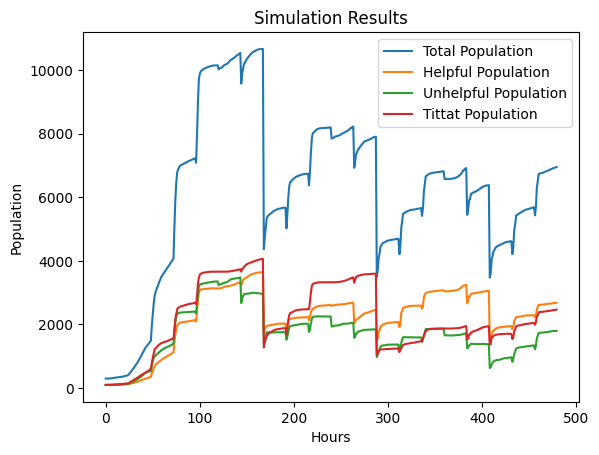

: 

In [31]:
import matplotlib.pyplot as plt

# existing code to generate the plot
fig, ax = plt.subplots()
ax.plot(SIMULATION['results']['total_pop'], label='Total Population')
ax.plot(SIMULATION['results']['helpful_pop'], label='Helpful Population')
ax.plot(SIMULATION['results']['unhelpful_pop'], label='Unhelpful Population')
ax.plot(SIMULATION['results']['tittat_pop'], label='Tittat Population')
ax.set_xlabel('Hours')
ax.set_ylabel('Population')
ax.set_title('Simulation Results')
ax.legend()

# adding the parameters as text above the plot
params_str = f"QLEARNING: \nLEARNING_RATE={LEARNING_RATE}  START_EXPLORATION_PROB={START_EXPLORATION_PROB}\nMIN_EXPL_PROB={MIN_EXPLORATION_PROB}\nDISCOUNT={DISCOUNT}\nEXPL_RATE_DECAY={EXPL_RATE_DECAY}\nREPRODUCTION_REWARD={REPRODUCTION_REWARD}\nVISION_RADIUS={VISION_RADIUS}  VISION_MOVEMENT_PROBABILITY={VISION_MOVEMENT_PROB}\n"
env_str = f"ENVIRONMENT: \nINITIAL_HELPFUL={INITIAL_HELPUL_POP}  INITIAL_TITTAT={INITIAL_TITTAT_POP}  INITIAL_UNHELPFUL={INITIAL_UNHELPFUL_POP}\nCANTEEN_COUNT={CANTEEN_COUNT}  CANTEEN_FOOD_PER_PERSON={CANTEED_FOOD_PER_PERSON}  CANTEEN_FOOD_DAILY_LIMIT={CANTEEN_DAILY_FOOD_LIMIT}\nGHOST_VAL={GHOST_VAL}\nREPRODUCTION_THRESHOLD={FOOD_THRESHOLD_FOR_REPRODUCTION}\nFOOD_LOST_PER_MOVE={FOOD_PER_MOVE}\n"
text_str = params_str + env_str
fig.text(0.1, 0.95, text_str, fontsize=10)

plt.savefig(f'SIMULATION_{simulation_no}.png', dpi=300, bbox_inches='tight')
plt.show()